In [244]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [245]:
n = 30  # number of tokens
d_model, d_attn, d_value = 10, 4, 5 # dm, da, dv
scale = 1.0 / np.sqrt(d_attn)
X = torch.randn(n, d_model)
Wq = torch.randn(d_model, d_attn)
Wk = torch.randn(d_model, d_attn)
Wv = torch.randn(d_model, d_value)

def self_attention(X, Wq, Wk, Wv, scale=1.0):
    Q = X @ Wq * scale # [n, da]
    K = X @ Wk * scale # [n, da]
    V = X @ Wv # [n, dv]
    scores = Q @ K.T # or torch.einsum('il,jl->ij', Q, K); [n,n]              
    attn = torch.softmax(scores, axis=1) # [n,n]
    Y = attn @ V # or torch.einsum('ij,jd->id', attn, V); [n, dv]
    return Y

Y = self_attention(X, Wq, Wk, Wv, scale=scale)

In [246]:
Wk1 = torch.randn(d_model, d_attn)
Wk2 = torch.randn(d_model, d_attn)

def self_attention_3d(X, Wq, Wk1, Wk2, Wv):
    Q = X @ Wq # [n, da]
    K1 = X @ Wk1 # [n, da]
    K2 = X @ Wk2 # [n, da]
    V = X @ Wv # [n, dv]
    scores = torch.einsum('il,jl,kl->ijk', Q, K1, K2) # [n, n, n]
    attn = torch.softmax(scores.reshape(n, -1), dim=1).reshape(n, n, n) # [n, n, n]
    Vjk = torch.cat([V.unsqueeze(1)+V.unsqueeze(0)], dim=0) # [n, n, dv]
    Y = torch.einsum('ijk,jkd->id', attn, Vjk) # [n, dv]
    return Y

Y_3d = self_attention_3d(X, Wq, Wk1, Wk2, Wv)

In [255]:
def rff_attention(X, Wq, Wk, Wv, sigma=1.0, N=1024, eps=1e-8):
    Q = X @ Wq # [n, da]
    K = X @ Wk # [n, da]
    V = X @ Wv # [n, dv]
    omega = torch.randn(d_attn, N) / sigma # [da, N]

    def phi(T): 
        TOm = T @ omega # [n, N]
        return torch.cat([torch.cos(TOm), torch.sin(TOm)], -1) / N**0.5 # [n, 2N]

    phiQ = phi(Q)  # [n, 2N]
    phiK = phi(K)  # [n, 2N]
    CK = torch.exp((K**2).sum(axis=1, keepdims=True) / (2 * sigma**2)) # [n, 1]

    S = (phiK*CK).T @ V  # [2N, dv]
    D = torch.sum(phiK * CK, axis=0, keepdim=True) # [1, 2N]
    
    denom = phiQ @ D.T  # [n, 1]
    numer = phiQ @ S    # [n, dv]
    return numer / (denom + eps)

Y_rfa = rff_attention(X, Wq, Wk, Wv, sigma=1/scale, N=1024)

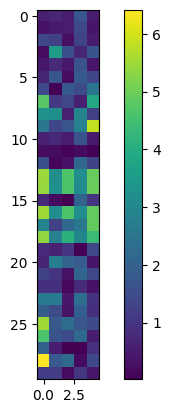

In [256]:
plt.imshow(torch.abs(Y_rfa - Y).detach().numpy())
plt.colorbar()